In [92]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

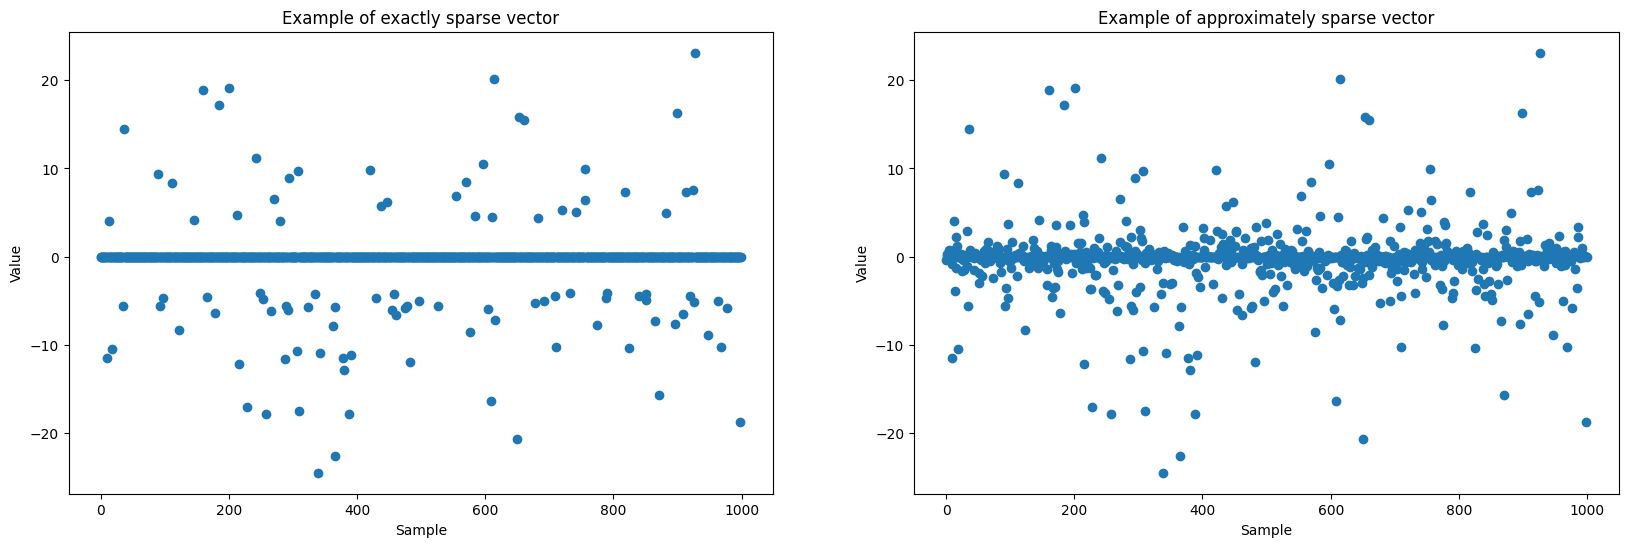

In [93]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answer:**
- Exact sparsity : A signal is said to be $k$-sparse if only $k$ of its elements are non-zeros, denoted as $||s||_0=k<<t$, where t is the lenght of the signal . In other words it is a signal that has few non-zero values.
- Approximate sparsity : An approximately sparse signal is one where a small number $k$ of the signal samples have a large amplitude. In this case, the signal can be effectively approximated by a $k$-sparse signal.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

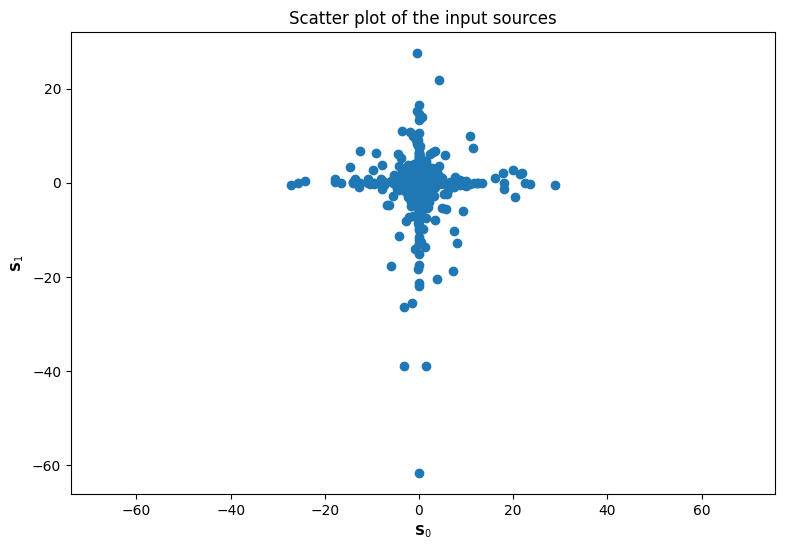

In [94]:
n = 2        # number of sources (rows)
t = 1024      # number of samples (columns)
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.

S = np.random.randn(n, t)**power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

**Answer:**

We obtain a cross formed by non-zero values centred around the point (0,0) and distributed close to the x-axis and the y-axis. The plot allows us to see the sparsity of the two sources.

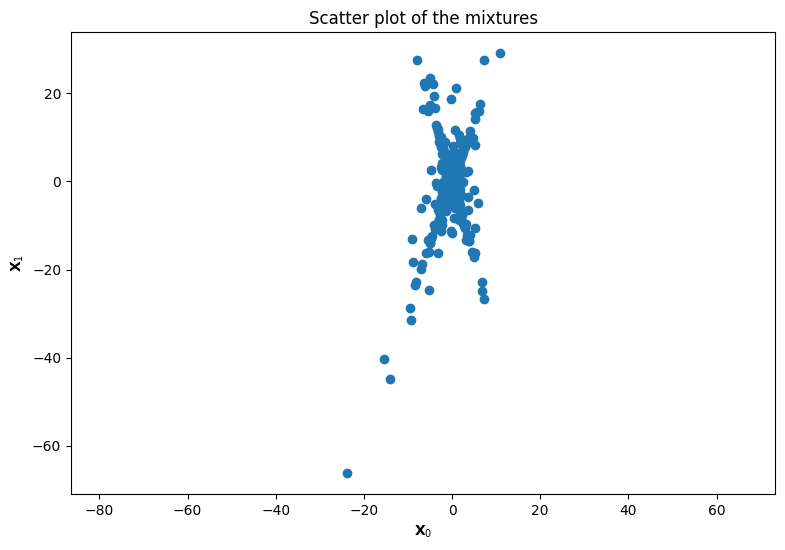

In [95]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the mixtures')
plt.plot(X[0, :], X[1, :], 'C0o')
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');
plt.show()

Plot the scatter plot of X. What do you see ?

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

**Answer:**

After multiplying the source $S$ with the matrix $A$, the plot has changed : the lines on which the points were distributed have changed directions, the new directions are the directions of the columns of the mixing matrix $A$.

As we inrease the power, the points are less scattered and more concentrated around the two axes ( for power 1 we get a scattered cloud of points).

As we increase te noise level, the points get more randomly distributed, but if the power is big enough, we can barely see the impact of the noise.

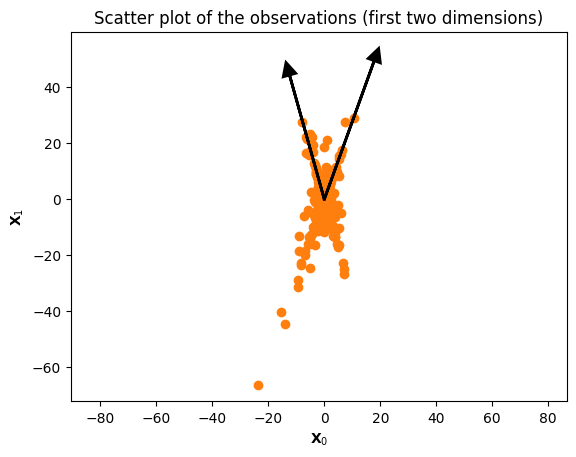

In [96]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

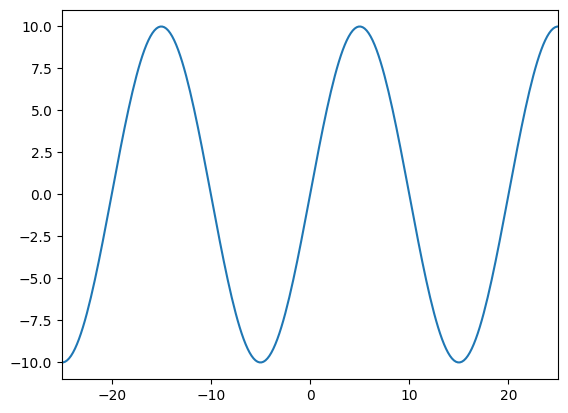

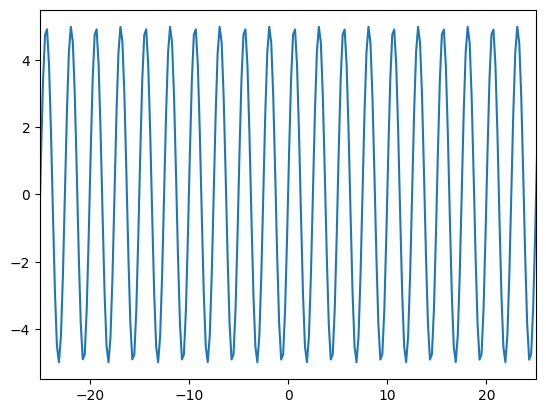

In [97]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

**Answer:**

The Discrete cosine transform of a sine function is just a peak on the corresponding frequency, so it allows a simple and clear representation of the signal $S$ in the frequency domain, since it will be represented by two peaks.

When we change the frequencies of the sources, the peaks in the frequency domains change place to the new frequencies.

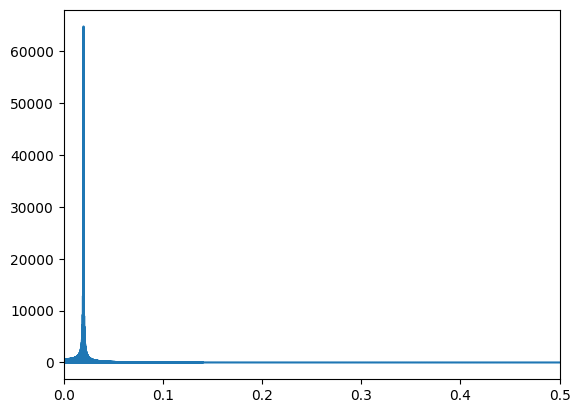

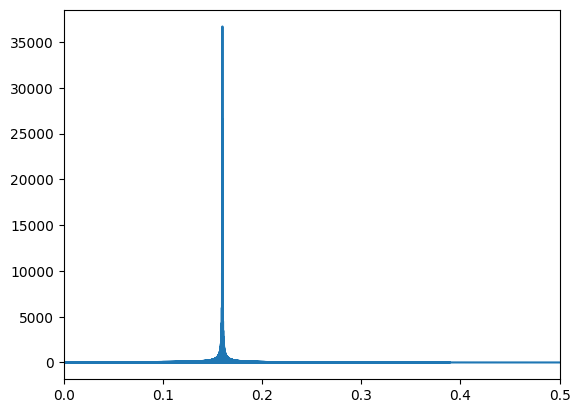

In [98]:
# Transformation into the DCT domain
Sf = sff.dct(S)
f = np.linspace(0,1,t)
plt.figure(),plt.plot(f,np.abs(Sf[0,:]))
plt.xlim([0,0.5])
plt.figure(),plt.plot(f,np.abs(Sf[1,:]))
plt.xlim([0,0.5])
plt.show()

Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Answer:**

We observe two peaks because we have two sinusoids with diffirent frequencies. To recover the sources, we use the shannon theorem and we isolate one peak and recover the corresponding source by applying the inverse of the DCT.

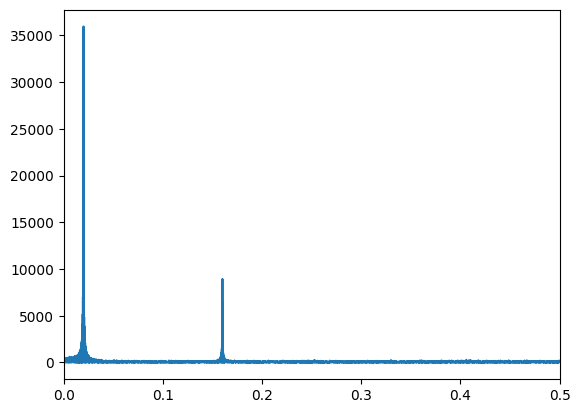

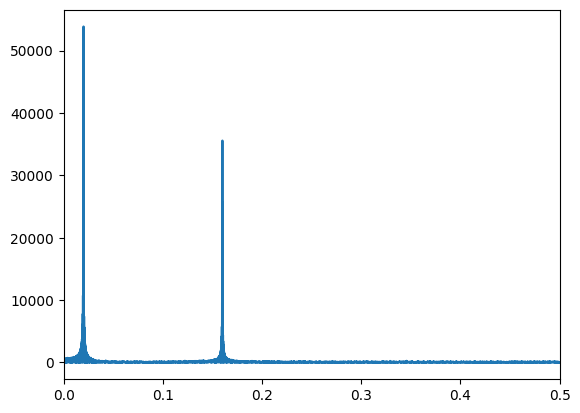

In [99]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# Transformation into the DCT domain
Xf = sff.dct(X)
f = np.linspace(0,1,t)
plt.figure(),plt.plot(f,np.abs(Xf[0,:]))
plt.xlim([0,0.5])
plt.figure(),plt.plot(f,np.abs(Xf[1,:]))
plt.xlim([0,0.5])
plt.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


Compute the gradient along the S variable of the data-fidelity term.

Recall what the proximal operator of the l1-norm is.

**Answer:**

- Cost function: $$ f(S)= \frac 1 2 ||X-AS||^2_F + \lambda ||S||_1$$
The first term is the data attachement term, it is smooth since it is the norm $l_2$. The second term is the regularisation term that ensures sparsity of the solution, it is not smooth since it is the norm $l_1$. The cost function is convex as the sum of two convex functions.
- The gradient of the data attachement term over $S$: $$ \nabla_S f(S) = A^{\top}(AS-X)$$
- The proximal operator of the $l_1$-norm: 
$$(prox_{\lambda|.|_1}(S))_i = sign(s_i)max(|s_i|-\lambda,0)
    = \begin{cases}  
        s_i - \lambda & \text{if } s_i > \lambda \\
        0 & \text{if } |s_i| \leq \lambda \\
        s_i + \lambda & \text{if } s_i < -\lambda
    \end{cases} $$

In [100]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
    S_est = np.sign(S_est)*np.maximum(np.abs(S_est)-thrd,0)
    return S_est

Explain the main idea of the ISTA algorithm. Then, implement it.

In [101]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    
    S_est = np.zeros((n,np.shape(X)[1]))
    L = np.linalg.norm(A.T@A)
    gamma = 1/L

    for i in range(nbIt):
        S_est = prox_l1(S_est + gamma*A.T@(X - A@S_est),lamb)
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

**Answer:** 

If we choose too big values of $\lambda$, the regularisation term will be more important than the data attachment term, the the solution will tend towards zero and not the desired value that minimises the squared error $||X-AS||^2_F$.

In [102]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

**Answer:**

In the DCT domain, we find one peak for each source which is what we expected since we know that we want to find sine functions.

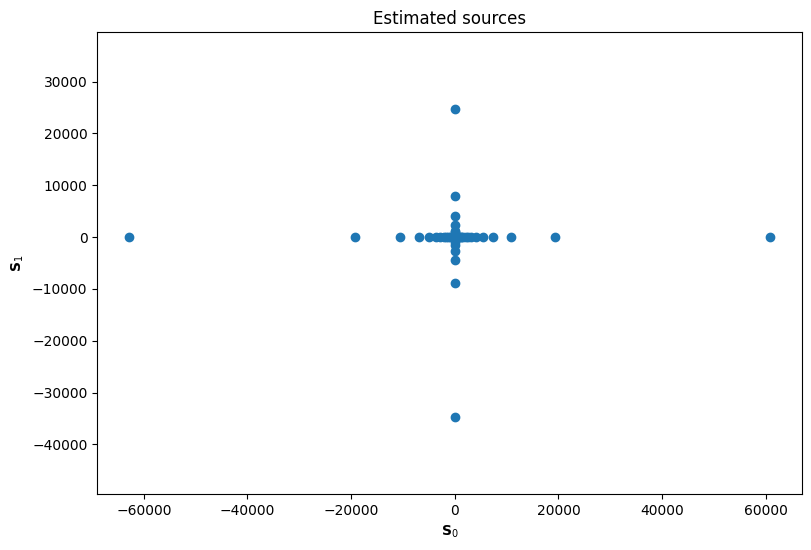

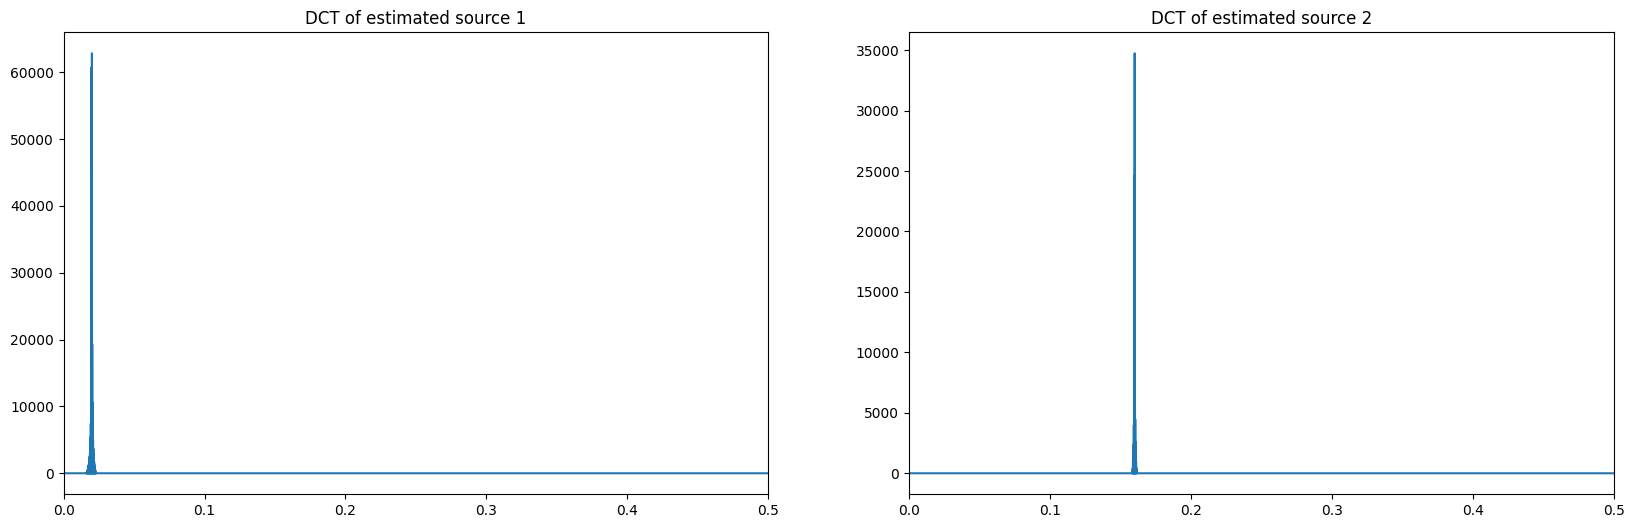

In [103]:
# Plot the estimated sources
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Estimated sources')
plt.plot(S_estf[0,:], S_estf[1,:], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');
plt.show()

# Plot DCTs
fig = plt.figure(figsize=(20, 6))  
fig.add_subplot(1,2,1)
plt.plot(f,np.abs(S_estf[0,:]))
plt.title('DCT of estimated source 1')
plt.xlim([0,0.5])
fig.add_subplot(1,2,2)
plt.plot(f,np.abs(S_estf[1,:]))
plt.title('DCT of estimated source 2')
plt.xlim([0,0.5])
# Add titles
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

**Answer:**

By applying the inverse DCT, we recover the sine functions of the original sources with the same frequencies. The only difference is that the amplitudes of these sines are bigger than the amplitudes of the original sources. We don't have energy conservation ! We have to add a constraint to the cost function to limit the energy.

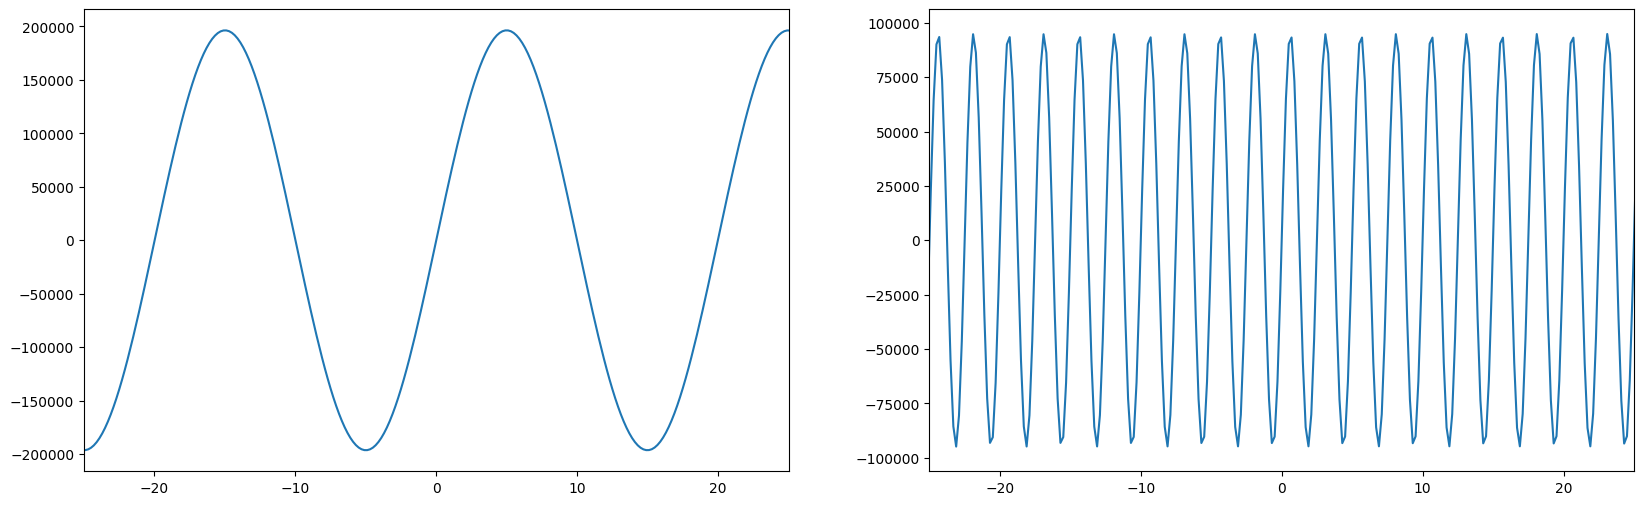

In [104]:
# Transform the sources back in the direct domain using the inverse DCT
S_est = sff.idct(S_estf)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(x_abs,S_est[0,:])
plt.xlim([-25,25])
fig.add_subplot(1,2,2)
plt.plot(x_abs,S_est[1,:])
plt.xlim([-25,25])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

**Answer:**
- Cost function for the blind sparse source separation : 
$$ f(A,S)=\frac 1 2 ||X-AS||^2_F + \lambda ||S||_1 + i_{\{\forall i, ||A_i||^2_2=1\}}(A)$$
The first term is the data attachement term, which is smooth thanks to the $l_2$-norm. The second term is the regularisation/sparsity term, which is not smooth because of the $l_1$-norm. The last term is the oblique constarint that limits the energy of the columns ($A_i$) of the mixing matrix $A$, it is not smooth because of the indicator function. However, we can use the proximal operators to optimize these non differentiable terms.

The two first terms are convex, but the indicator function is not, so the cost function is not convex, so there is no unique minima.

Recall what the gradient of the data fidelity term over A is.

**Answer:**
- The gradient of the data attachement term over $A$ : $$\nabla_A f(A) = (AS - X)S^{\top} $$

Compte the proximal operator of the oblique constraint. Implement it.

In [105]:
def prox_oblique(A):
    # scaling columns of A to have unitary norm
    A = A/np.linalg.norm(A,axis=0)
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [106]:
def PALM(X,n=2,lamb=100,nbIt = 100):
    m,t = np.shape(X)
    S_est = np.zeros((n,t))
    A_est = np.eye(n)
    
    for i in range(nbIt):
        gamma = 0.9/np.linalg.norm(A_est@A_est.T + 1e-20)
        S_est = prox_l1(S_est + gamma*A_est.T@(X - A_est@S_est),lamb)
        eta = 1/np.linalg.norm(S_est@S_est.T + 1e-20)
        A_est = prox_oblique(A_est + eta*(X - A_est@S_est)@S_est.T)
   
    return S_est, A_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

Estimated mixing matrix A: [[0.55478456 0.24259125]
 [0.83199404 0.97012859]]
Real A: [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]


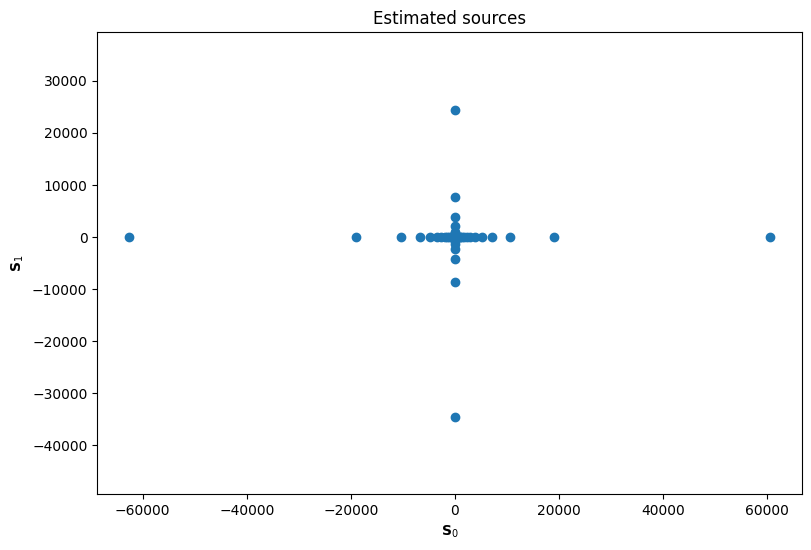

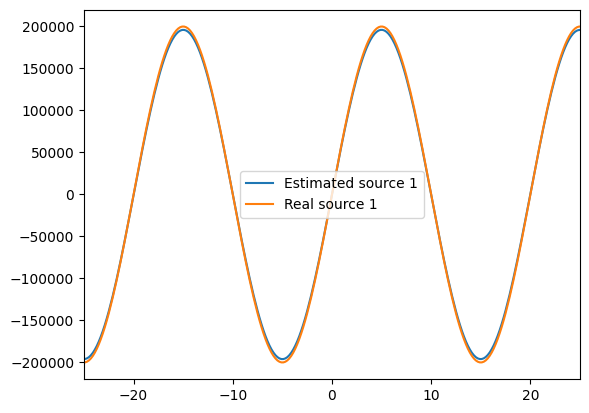

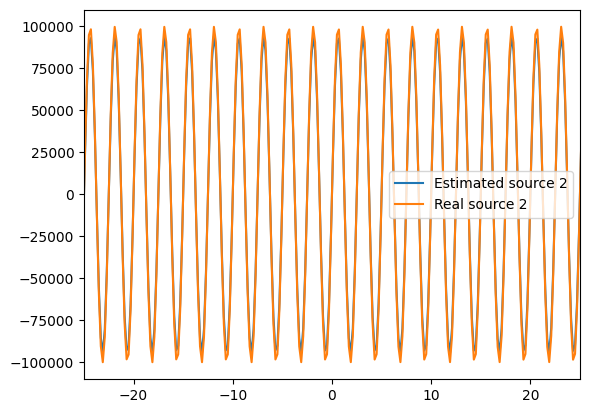

In [107]:
# Test the PALM algorithm on the simulated data
S_est, A_est = PALM(Xf,n=2,lamb=1000,nbIt = 1000)

print('Estimated mixing matrix A:', A_est)
print('Real A:', A)

# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 200000*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 100000*np.sin(2*np.pi*0.4*x_abs)

# Plot the estimated sources
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Estimated sources')
plt.plot(S_est[0,:], S_est[1,:], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');
plt.show()

# Inverse DCT and Superposition with the original sources
S_est = sff.idct(S_est)
plt.plot(x_abs,S_est[0,:], label='Estimated source 1')
plt.plot(x_abs,S[0,:], label='Real source 1')
plt.xlim([-25,25])
plt.legend()
plt.show()
plt.plot(x_abs,S_est[1,:], label='Estimated source 2')
plt.plot(x_abs,S[1,:], label='Real source 2')
plt.xlim([-25,25])
plt.legend()
plt.show()

**Answer:**

Using the PALM algorithm, we get a good separationg of the sources and they are identical to the generated sources. We also get a good approximation of the mixing matrix $A$.